# <a name="config"></a>Конфигурация

Компилятор:
* Microsoft (R) C/C++ Optimizing Compiler Version 18.00.21005.1 for x64

Тест запускался на машине следующей конфигурации (1 CPU):

* Number of cores: 4
* Name: Intel Core i5 2400  
* Codename: Sandy Bridge  
* Specification: Intel(R) Core(TM) i5-2400 CPU @ 3.10GHz
* L1 Data cache: 4 x 32 KBytes, 8-way set associative, 64-byte line size  
* L1 Instruction cache: 4 x 32 KBytes, 8-way set associative, 64-byte line size  
* L2 cache: 4 x 256 KBytes, 8-way set associative, 64-byte line size  
* L3 cache: 6 MBytes, 12-way set associative, 64-byte line size

Испытания проводились для матриц над *float(4B)* и над *double(8B)* с размерностями от *1000* до *2000*. Для фиксированной размерности матрицы делалось *5* прогонов *Simple*, *Block* и *Swapped* алгоритмов с замерами по времени. На выходе получили два файла [*cache_float.txt*](cache_float.txt) и [*cache_double.txt*](cache_double.txt).

# Результаты тестирования

На рисунках ниже представлены результаты проведенного тестирования. Графики приведены для случаев матриц над *float* и над *double*. Рассматриваются диапазоны размерностей от *1000* до *1100* и от *1000* до *2000*.

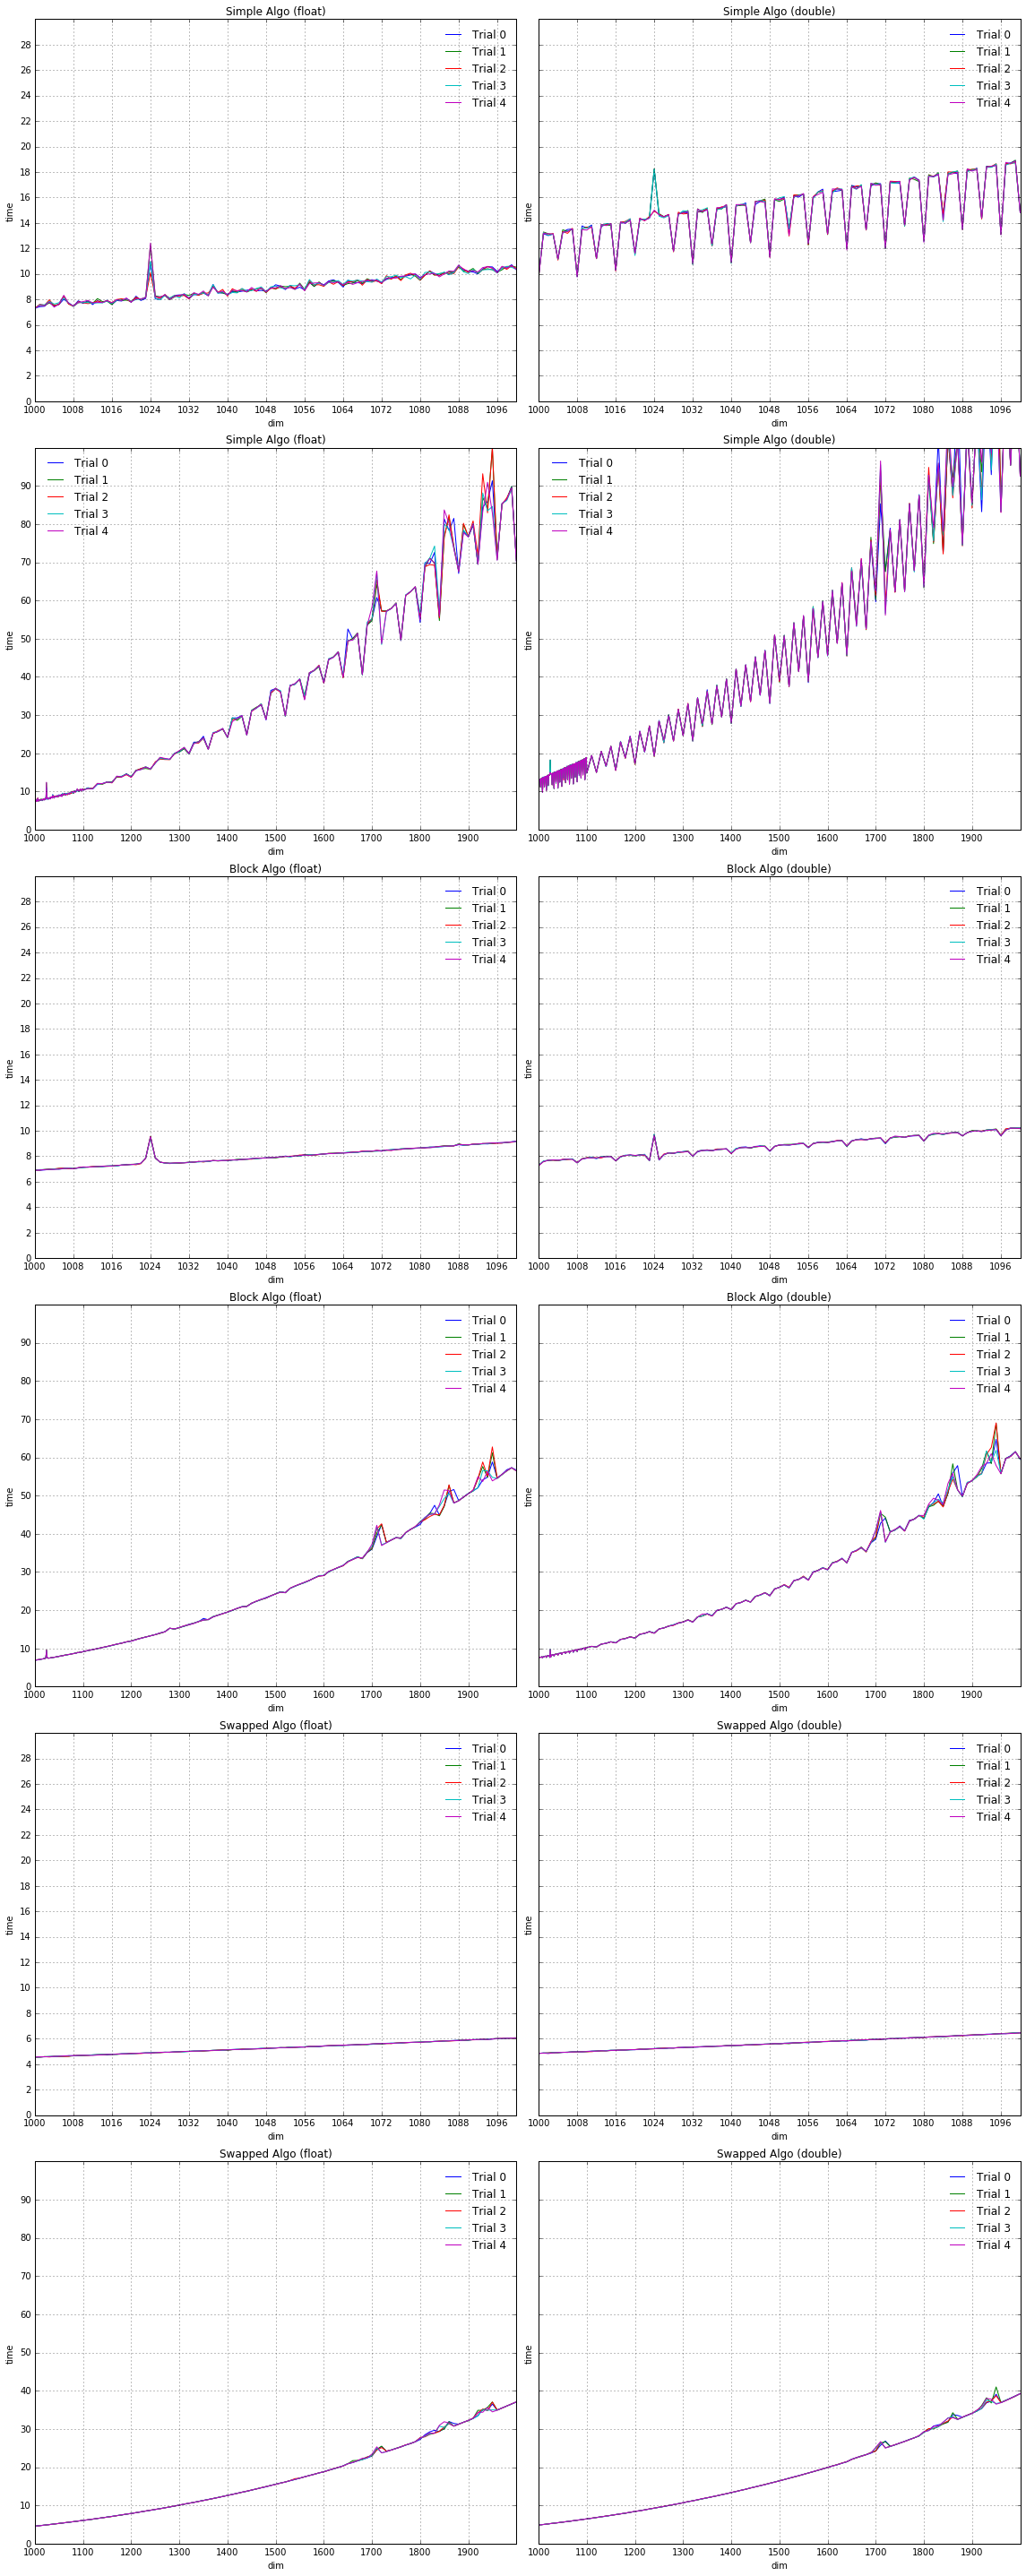

In [113]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


algos = ("Simple Algo (float)", "Block Algo (float)", "Swapped Algo (float)", \
         "Simple Algo (double)", "Block Algo (double)", "Swapped Algo (double)")

def parse_recs(filename, algos, trial_num = 5):
    '''
        parse the input file of the format as:
        [dim_val1]\t[algo1_time]\t[algo2_time]...\n X trial_num times
        [dim_val2]\t[algo1_time]\t[algo2_time]...\n X trial_num times
        ...
    '''
    xs = []
    ts = {}
    for algo in algos:
        ts[algo] = [[] for i in xrange(trial_num)]
    cnt = 0
    for line in open(filename, "r"):
        tkns = line.split("\t")
        if len(tkns) != len(algos)+1:
            raise ValueError("Invalid file format")
        x = int(tkns[0])
        if cnt % trial_num == 0:
            xs.append(x)
        for i, algo in enumerate(algos):
            ts[algo][cnt % trial_num].append(float(tkns[i+1]))
        cnt+=1
    return xs, ts

xs, ts_fl = parse_recs("cache_float.txt", algos[:3])
xs, ts_dd = parse_recs("cache_double.txt", algos[3:])

# utility method
def ax_draw(ax, title, xlbl, ylbl, xlim, xtick, ylim, ytick, xs, ts, trial_num = 5):
    ax.set_title(title)
    for i in xrange(trial_num):
        ax.plot(xs, ts[i], label="Trial %d" % i)
    ax.set_xlabel(xlbl)
    ax.set_xlim(xlim)
    ax.set_xticks(range(xlim[0], xlim[1], xtick))
    ax.set_ylabel(ylbl)
    ax.set_ylim(ylim)
    ax.set_yticks(range(ylim[0], ylim[1], ytick))
    ax.grid(True)
    ax.legend(loc='best', frameon=False)

fig, axarr = plt.subplots(6, 2, sharey="row", figsize=(16, 40))
for i in xrange(0, 6, 2):
    ax_draw(axarr[i][0], algos[i//2], "dim", "time", [1000, 1100], 8, [0, 30], 2, xs, ts_fl[algos[i//2]])
    ax_draw(axarr[i][1], algos[i//2+3], "dim", "time", [1000, 1100], 8, [0, 30], 2, xs, ts_dd[algos[i//2+3]])
    ax_draw(axarr[i+1][0], algos[i//2], "dim", "time", [1000, 2000], 100, [0, 100], 10, xs, ts_fl[algos[i//2]])
    ax_draw(axarr[i+1][1], algos[i//2+3], "dim", "time", [1000, 2000], 100, [0, 100], 10, xs, ts_dd[algos[i//2+3]])
plt.tight_layout()
plt.show()


*временной всплеск в районе 1700~1900 - моя оплошность: вернулся с работы и начал активно эксплуатировать компьютер:( При оценке общего тренда этот участок можно игнорировать

# Анализ результатов

* Во-первых, общий характер зависимости времени работы от размерности входных матриц у всех алгоритмов одинаковый - кубический.
* Во-вторых, время работы *Swapped* алгоритма в среднем в *1.5* раза лучше времени *Block* алгоритма. В свою очередь, *Block* алгоритм отработал в среднем в *1.5* раза лучше *Simple* алгоритма. Такой результат объясняется *улучшением локальности* алгоритмов от первого *Simple* к третьему *Swapped*.
* В-третьих, как в случае с *float*, так и в случае с *double* алгоритмы *Simple* и *Block* резко ухудшают время своей работы для размерности матриц 1024. Это связано с большим числом *cache miss-ов* при проходе по столбцам мартицы такой размерности. В блочном алгоритме мы получаем лучшую производительность за счет улучшения локальности в пределах одного блока. Но невозможность использования кэша полностью все равно отражается на времени работы. Для наглядности рассмотрим процесс мэпинга физических адресов элементов матрицы на *cache-set-ы* кэша. За основу возьмем L3 кэш (считаем, что в нем данные все еще легко доступны для процессора), описанный в [первом пункте](#config). Рассчитаем число возможных индексов *cache-set-ов*: 
$$cache\_set\_num=\frac{total\_size}{cache\_line\_size * channel\_num}=\frac{6 * 2^{20}B}{64B * 12}=2^{13}$$
Таким образом, индексы могут принимать любые значения из группы $Z_{2^{13}}$.
Положим, что адрес первого элемента столбца матрицы равен $addr$, тогда адреса остальных элементов этого стобца будут отображаться на индексы: $$cache\_set\_index=\frac{addr + sizeof(type) * dim * irow}{cache\_line\_size}mod(cache\_set\_num)$$
Для случая с float получим:
$$cache\_set\_index=(\frac{addr + 4*dim*irow}{64})mod(2^{13})$$
Для double имеем:
$$cache\_set\_index=(\frac{addr + 8*dim*irow}{64})mod(2^{13})$$
В ситуации, когда $16\nmid dim$ для *float* или $8\nmid dim$ для *double*, предсказать теоретически число используемых *cache-set-ов* сложно. Но для объяснения феномена *1024* нам достаточно рассмотреть формулы выше в предположении кратности $dim$ *16* и *8*.
Тогда для *float* перепишем:
$$cache\_set\_index=(c+\frac{dim}{16}*irow)mod(2^{13})$$
Для *double*:
$$cache\_set\_index=(c+\frac{dim}{8}*irow)mod(2^{13})$$
В обоих случаях, индексы берутся не из всей группы $Z_{2^{13}}$, но из некоторой ее циклической подгруппы, порожденной для *float* и *double* элементами $\frac{dim}{16}$ и $\frac{dim}{8}$ соответственно (c - константа, для подсчета порядка можем ею пренебречь). Порядки этих подгрупп (число используемых *cache-set-ов*) можно рассчитать как:
$$ord\_float=\frac{2^{13}}{gcd(2^{13},\frac{dim}{16})}$$
и
$$ord\_double=\frac{2^{13}}{gcd(2^{13},\frac{dim}{8})}$$
Есди взять $dim=1024$, получим $ord\_float=\frac{2^{13}}{64}=128$ и $ord\_double=\frac{2^{13}}{128}=64$. Количество используемых *cache-set-ов* мало, поэтому при переходе ко второму столбцу матрицы большинство необходимых нам кэш линий будут уже перезаписаны. Соответсвенно, будем получать много *cache-miss-ов* и большее время работы алгоритма.
* В-четвертых, легко можно заметить пилообразную форму кривых для *Simple* и *Block* алгоритмов. Причем, отметим, что частота пиков для *double* выше, чем для *float* примерно в 2 раза. Поскольку общий случай здесь снова достаточно сложно оценить, ограничимся рассмотрением случая, когда $16\mid dim$ для *float* или $8\mid dim$ для *double*. Выше было показано, как можно по размерности матриц оценить количество используемых *cache-set-ов* (см. формулы выше). Очевидно, что максимальное значение этого параметра мы получим для тех $dim$, для которых $gcd(2^{13}, \frac{dim}{16}) == 1$ для *float* и $gcd(2^{13}, \frac{dim}{8}) == 1$ для *double* (в этом случае соответствующие элементы $\frac{dim}{16}$ и $\frac{dim}{8}$ будут порождающими для всей группы $Z_{2^{13}}$). Найдем эти размерности.  
Для *float*:

In [138]:
import fractions as  frac
dim_float = [x for x in xrange(1000, 2001) if x % 16 == 0 and frac.gcd(2**13, x/16) == 1]
print "len: %d\n%s" % (len(dim_float), dim_float)

len: 32
[1008, 1040, 1072, 1104, 1136, 1168, 1200, 1232, 1264, 1296, 1328, 1360, 1392, 1424, 1456, 1488, 1520, 1552, 1584, 1616, 1648, 1680, 1712, 1744, 1776, 1808, 1840, 1872, 1904, 1936, 1968, 2000]


    Для double:

In [139]:
dim_double = [x for x in xrange(1000, 2001) if x % 8 == 0 and frac.gcd(2**13, x/8) == 1]
print "len: %d\n%s" % (len(dim_double), dim_double)

len: 63
[1000, 1016, 1032, 1048, 1064, 1080, 1096, 1112, 1128, 1144, 1160, 1176, 1192, 1208, 1224, 1240, 1256, 1272, 1288, 1304, 1320, 1336, 1352, 1368, 1384, 1400, 1416, 1432, 1448, 1464, 1480, 1496, 1512, 1528, 1544, 1560, 1576, 1592, 1608, 1624, 1640, 1656, 1672, 1688, 1704, 1720, 1736, 1752, 1768, 1784, 1800, 1816, 1832, 1848, 1864, 1880, 1896, 1912, 1928, 1944, 1960, 1976, 1992]


    Как видим, в обоих случаях значения распределены равномерно по отрезку [1000,2000] и для double их в среднем в 2 раза  
    больше, чем для float. Если соотнести полученные значения размерностей матриц с данными на графиках Simple Algo и  
    Block Algo, то мы как раз и увидим прирост скорости в этих точках (лучше смотреть Simple Algo, так как в Block Algo  
    за счет блочности происходит своего рода сглаживание).

* Последнее. *Swapped* алгоритм оказался неподвержен нежелательным эффектам, связаным с неэффективным использованием кэша, потому что в нем вертикальный проход по матрице был заменен на продольный. В этом случае мы получаем высокий коэффициент переиспользования данных, чем и объясняется быстродействие последнего алгоритма.